In [8]:
from roi import equity, external, utilities, macro, metrics, cost, surveys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [9]:
bls_api_key = "c8803d0ba66c4592b8b0eff68ac9ebb0"

In [10]:
data = pd.read_csv("testing/testing-data/test_microdata.csv")

In [11]:
programs = pd.read_csv("testing/testing-data/programs.csv")

In [12]:
data.columns

Index(['Unnamed: 0', 'race', 'gender', 'earnings_start', 'earnings_end', 'age',
       'program', 'program_start', 'program_end', 'education_level',
       'completer', 'employed_at_end', 'employed_at_start', 'state',
       'full_address', 'Address', 'City', 'State', 'Zip', 'id', 'start_month',
       'end_month'],
      dtype='object')

__Equity analysis__

In [13]:
gini = equity.Gini.from_dataframe(data, 'gender', 'earnings_end', sample = 2000)
gini.calculate()

/Users/mattlerner/roi/sbir-roi/roi/equity.py:77: UserWarning: When sample == True, Metric() will use the value of sample to create a random subset of values that it will use for all calculations. This number will be stored as attribute .samplesize.
  warnings.warn("When sample == True, Metric() will use the value of sample to create a random subset of values that it will use for all calculations. This number will be stored as attribute .samplesize.")
/Users/mattlerner/roi/sbir-roi/roi/equity.py:61: UserWarning: Data passed contains 89 NA values. All equity metrics are calculated by ignoring NA values, in effect dropping them. Please ensure that you have a strategy for dealing with these missing values. If values are not missing at random, e.g. if individuals with missing values have common traits, then ALL METRICS calculated will be biased.
  warnings.warn("Data passed contains {} NA values. All equity metrics are calculated by ignoring NA values, in effect dropping them. Please ensure

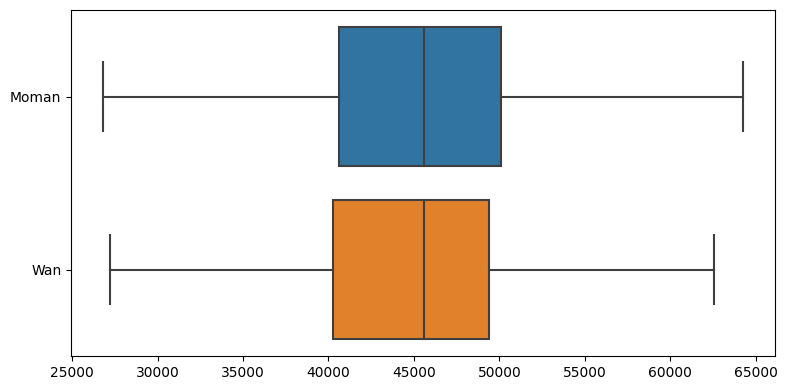

In [14]:
gini.viz

In [ ]:
gini.ratio

In [ ]:
gini.sample

__Geocode addresses__

In [ ]:
small_data = data.sample(30)

In [ ]:
small_data.head()

In [ ]:
small_data['geocode'] = external.Census.get_batch_geocode(small_data)

__Get SES for each individual with a geocode__

In [ ]:
adi = equity.ADI()

In [ ]:
small_data['ses'] = adi.get_quintile_for_geocodes_frame(small_data, 'geocode')

In [ ]:
small_data.head()

__Check out SES equity concerns__

In [ ]:
theil_t = equity.Theil_T.from_dataframe(small_data, 'ses', 'earnings_end')

In [ ]:
theil_t.calculate()

In [ ]:
theil_t.viz

In [ ]:
theil_t.ratio

__Calculate graduate wage summary statistics__

In [ ]:
fig, ax = plt.subplots()
data['earnings_end'].hist(ax=ax, edgecolor="red", fc=(0, 0, 0, 0.5), bins=30)
plt.axvline(x=np.mean(data['earnings_end']))

In [ ]:
utilities.multiple_describe(data, 'program', 'earnings_end')

__Adjust wages for inflation__

In [ ]:
bls = macro.BLS_Ops()
data['earnings_end_adjusted'] = bls.adjust_to_current_dollars(data, 'program_end', 'earnings_end')

In [ ]:
data[['program_end','earnings_end','earnings_end_adjusted']].sample(10)

__Recalculate average graduate wage by program__

In [ ]:
fig, ax = plt.subplots()

# unadjusted
data['earnings_end'].hist(ax=ax, edgecolor="red", fc=(0, 0, 0, 0), bins=30)
plt.axvline(x=np.mean(data['earnings_end']), color="red", linestyle=":")

# adjusted
data['earnings_end_adjusted'].hist(ax=ax, edgecolor="blue", fc=(0, 0, 0, 0), bins=30)
plt.axvline(x=np.mean(data['earnings_end_adjusted']), color="blue", linestyle=":")

__Calculate earnings premium - Simple way__

In [ ]:
data['earnings_change'] = data['earnings_end'] - data['earnings_start']

In [ ]:
utilities.multiple_describe(data, 'program', 'earnings_change')

In [ ]:
sns.barplot(x="earnings_change", y="program", data=data, estimator=np.mean)

__Calculate earnings premium - Fancy way__

In [ ]:
data['year_month_entry'] = data['program_start'].astype(str) + '-' + data['start_month'].astype(str).str.zfill(2)
data['year_month_exit'] = data['program_end'].astype(str) + '-' + data['end_month'].astype(str).str.zfill(2)

In [ ]:
data

In [ ]:
data['macro_wage_change'] = bls.wage_change(data, 'State','year_month_entry','year_month_exit')

In [ ]:
data['State']

In [ ]:
data['state_fips'] = utilities.State_To_FIPS_series(data['State'])

In [ ]:
data[['State','state_fips']]

In [ ]:
data['macro_wage_change'] = bls.wage_change(data, 'state_fips','year_month_entry','year_month_exit')

In [ ]:
data.sample(10)

In [ ]:
data['trend_adjusted_change'] = data['earnings_change'] - data['macro_wage_change']

In [ ]:
# ignore this ugly cod
original_summary = utilities.multiple_describe(data, 'program', 'earnings_change')
adjusted_summary = utilities.multiple_describe(data, 'program', 'trend_adjusted_change')
original_summary['calculation'] = "original"
adjusted_summary['calculation'] = "adjusted"

sns.barplot(x="mean", y="program", hue="calculation", data=pd.concat([original_summary, adjusted_summary]))

__Calculate earnings premium - VERY fancy way__

In [ ]:
premium = metrics.Earnings_Premium(data, 'state_fips', 'education_level', 'earnings_start', 'earnings_end', 'program_start', 'program_end', 'age')

In [ ]:
data['predicted_wage'] = premium.predicted_wage
data['earnings_premium'] = premium.full_premium

In [ ]:
data.sample(5)

In [ ]:
# Mean predicted vs actual wage by program
original_summary = utilities.multiple_describe(data, 'program', 'earnings_end')
adjusted_summary = utilities.multiple_describe(data, 'program', 'predicted_wage')
original_summary['value'] = "actual"
adjusted_summary['value'] = "predicted"

sns.barplot(x="mean", y="program", hue="value", data=pd.concat([original_summary, adjusted_summary]))

In [ ]:
sns.barplot(x="earnings_premium", y="program", data=data, estimator=np.mean)

__Calculate employment premium__

In [ ]:
data

__Calculate time to completion and completion rate statistics__

In [ ]:
completion = metrics.Completion(data, 'program', 'program_start', 'program_end', 'employed_at_end')

In [ ]:
completion_time = completion.time_to_completion
completion_time

In [ ]:
completion_rate = completion.completion_rates
completion_rate

In [ ]:
sns.barplot(x="mean", y="program", data=completion_time).set_title("Average time to complete")

In [ ]:
sns.barplot(x="mean", y="program", data=completion_rate).set_title("Average completion rate")

__Try out loan amounts__

In [ ]:
data_programs = data.merge(programs, left_on="program", right_on="programs", how="left")
data_programs['total_cost'] = data_programs['cost_per_semester'] * data_programs['length']
data_programs['period_payment'] = cost.Compound_Interest_Loan.calculate_period_payment(data_programs['total_cost'], 0.05, 10)

In [ ]:
data_programs.sample(10)

In [ ]:
data_programs['premium_with_payments'] = data_programs['earnings_premium'] - data_programs['period_payment']

In [ ]:
summary_w_payments = utilities.multiple_describe(data_programs, 'program', 'premium_with_payments')

In [ ]:
sns.barplot(x="mean", y="program", data=summary_w_payments).set_title("Return including loan payments")

__High school baselines__

In [ ]:
cps = surveys.CPS_Ops()

In [ ]:
cps.rudimentary_hs_baseline('08', [1, 5, 10])

In [ ]:
{'year1': 15017.630256967966,
 'year5': 21688.246894625805,
 'year10': 34336.28062777556}

In [ ]:
states = ['CA','TX','AK','MS','CO']
fips = utilities.State_To_FIPS_series(states)

In [ ]:
fips

In [ ]:
baselines = pd.DataFrame([cps.rudimentary_hs_baseline(state, [1, 5, 10]) for state in fips])
baselines['state'] = states
baselines.columns = ['1','5','10','State']

In [ ]:
baselines_melted = pd.melt(baselines, id_vars=['State'], var_name="year", value_name="earnings")
baselines_melted['year'] = baselines_melted['year'].astype(int)
baselines_melted['earnings'] = baselines_melted['earnings'].astype(int)

In [ ]:
sns.lineplot(data=baselines_melted, x="year", y="earnings", hue="State")